In [1]:
import pandas as pd
from shapely.geometry import Point, Polygon
from functools import reduce
import json
import numpy as np
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import plotly
from plotly.graph_objs import Scatter, Figure, Layout, Histogram, Box
import plotly.graph_objs as go
import plotly.figure_factory as ff
import math
import geopandas as gpd
init_notebook_mode(connected=True)

In [2]:
df_correspondances = pd.read_csv("data/correspondance-code-insee-code-postal.csv", sep=";")

In [3]:
df_couverture = pd.read_csv("data/couverture.csv", sep=";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (0,3) have mixed types. Specify dtype option on import or set low_memory=False.



In [4]:
df_mobilite = pd.read_csv("data/mobilite.csv", sep=",")

In [5]:
df_presidentielle = pd.read_csv("data/presidentielle2017.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.



In [6]:
df_presidentielle["INSEE"] = df_presidentielle.INSEE.astype(str)

In [7]:
df_couverture["Couverture"] = [int(x[:-1]) for x in df_couverture["%T3 2018"]]

In [8]:
df_couverture["Code INSEE"] = df_couverture['Code commune']

In [9]:
df_mobilite["Code INSEE"] = df_mobilite['CODGEO']

In [10]:
df_communes = pd.read_excel("data/MDB-INSEE-V2.xls")

WARNING *** file size (57125979) not 512 + multiple of sector size (512)
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [11]:
df_communes.columns = ["Code INSEE"] + list(df_communes.columns)[1:]

In [12]:
df_communes.head(2)

,Code INSEE,Nb Pharmacies et parfumerie,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Orientation Economique,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,...,Score Croissance Entrepreneuriale,Score VA Région,Score PIB,Environnement Démographique,Fidélité,SYN MEDICAL,Seg Cap Fiscale,Seg Dyn Entre,DYN SetC,CP
0,01001,0.0,57.0,23.0,114,Bassin Industriel,101.93878,59.04139,0.0,0.0,...,0.01585,32.42578,33.83811,Bassin Industriel en croissance démographique,Pop Sédentaire,Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01
1,01002,0.0,45.0,4.0,143,Bassin Résidentiel,101.93878,59.04139,0.0,0.0,...,0.00173,32.42578,33.83811,Bassin Résidentiel en croissance démographique,Pop Sédentaire,Forte Synergie Médicale,Fiscalité moyenne,Faible dynamique,Faible Dynamique Serv et Com,01


In [13]:
df_correspondances.head(2)

,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
0,32460,32720,VERGOIGNAN,GERS,MIDI-PYRENEES,Commune simple,126.0,1056.0,0.3,"43.7235746425, -0.188266221507","{""type"": ""Polygon"", ""coordinates"": [[[-0.19884...",34962,460,24,3,32,73
1,51141,51240,LA CHAUSSEE-SUR-MARNE,MARNE,CHAMPAGNE-ARDENNE,Commune simple,130.0,2240.0,0.7,"48.8433156105, 4.54286173009","{""type"": ""Polygon"", ""coordinates"": [[[4.504753...",18178,141,33,4,51,21


In [14]:
del df_communes["Population"]

In [15]:
marseille_correspondance = df_correspondances[['MARSEILLE' in x and x.endswith("MENT") for x in df_correspondances["Commune"]]]
paris_correspondance = df_correspondances[['PARIS' in x and x.endswith("MENT") for x in df_correspondances["Commune"]]]
lyon_correspondance = df_correspondances[['LYON' in x and x.endswith("MENT") for x in df_correspondances["Commune"]]]

In [16]:
df_arrondissements = pd.DataFrame(np.array([["75056", "75000", "PARIS", "PARIS", "ILE-DE-FRANCE", "Préfecture de région",
 paris_correspondance["Altitude Moyenne"].mean(),
 0,
 0,
 "",
 "",
 0, 56, 22, 1, 75, 11
 ],
 ["13055", "13000", "MARSEILLE", "BOUCHES-DU-RHONE", "PROVENCE-ALPES-COTE D'AZUR",
 "Préfecture de région",
  marseille_correspondance["Altitude Moyenne"].mean(),
  0, 0, "", "", 0, 55, 99, 3, 13, 93
 ],
 ["69123", "69000", "LYON", "RHONE", "RHONE-ALPES", "Préfecture de région",
 lyon_correspondance["Altitude Moyenne"].mean(),
 0,
 0,
 "", "", 0, 123, 99, 1, 69, 82]
]), columns=df_correspondances.columns)

In [17]:
df_arrondissements

,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
0,75056,75000,PARIS,PARIS,ILE-DE-FRANCE,Préfecture de région,45.25,0,0,,,0,56,22,1,75,11
1,13055,13000,MARSEILLE,BOUCHES-DU-RHONE,PROVENCE-ALPES-COTE D'AZUR,Préfecture de région,119.0625,0,0,,,0,55,99,3,13,93
2,69123,69000,LYON,RHONE,RHONE-ALPES,Préfecture de région,191.77777777777777,0,0,,,0,123,99,1,69,82


In [18]:
c_temp = ['Altitude Moyenne', 'Superficie', 'Population', 'ID Geofla', 'Code Commune', 'Code Canton',
       'Code Arrondissement', 'Code Département', 'Code Région']
for x in c_temp:
    df_arrondissements[x] = pd.to_numeric(df_arrondissements[x])

In [19]:
df_correspondances = df_correspondances.append(df_arrondissements)

In [20]:
df_correspondances = df_correspondances.reset_index()

In [21]:
df_correspondances[[x.startswith("750") for x in df_correspondances["Code Postal"]]]

,index,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
441,441,75108,75008,PARIS-8E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,39.00,385.0,40.3,"48.8725272666, 2.31258256042","{""type"": ""Polygon"", ""coordinates"": [[[2.320781...",9859,108,22,1,75,11
525,525,75117,75017,PARIS-17E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,40.00,563.0,168.5,"48.8873371665, 2.30748555949","{""type"": ""Polygon"", ""coordinates"": [[[2.295145...",36583,117,31,1,75,11
4049,4049,75111,75011,PARIS-11E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,43.00,366.0,152.7,"48.8594154976, 2.37874106024","{""type"": ""Polygon"", ""coordinates"": [[[2.399114...",36586,111,25,1,75,11
4845,4845,75115,75015,PARIS-15E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,40.00,846.0,236.5,"48.8401554186, 2.29355937244","{""type"": ""Polygon"", ""coordinates"": [[[2.301320...",36581,115,29,1,75,11
12614,12614,75106,75006,PARIS-6E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,40.00,215.0,43.1,"48.8489680919, 2.33267089859","{""type"": ""Polygon"", ""coordinates"": [[[2.336591...",9608,106,20,1,75,11
12980,12980,75107,75007,PARIS-7E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,34.00,411.0,57.4,"48.8560825982, 2.31243868773","{""type"": ""Polygon"", ""coordinates"": [[[2.316633...",12976,107,21,1,75,11
15578,15578,75113,75013,PARIS-13E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,46.00,713.0,182.0,"48.8287176845, 2.36246822852","{""type"": ""Polygon"", ""coordinates"": [[[2.343909...",36579,113,27,1,75,11
19270,19270,75109,75009,PARIS-9E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,44.00,218.0,60.3,"48.8768961624, 2.33746024139","{""type"": ""Polygon"", ""coordinates"": [[[2.325754...",16867,109,23,1,75,11
19483,19483,75118,75018,PARIS-18E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,57.00,604.0,200.6,"48.8927350746, 2.34871193387","{""type"": ""Polygon"", ""coordinates"": [[[2.327115...",36584,118,32,1,75,11
20526,20526,75102,75002,PARIS-2E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,36.00,99.0,22.4,"48.8679033789, 2.34410716666","{""type"": ""Polygon"", ""coordinates"": [[[2.350834...",14312,102,16,1,75,11


In [22]:
for i, row in df_correspondances.iterrows():
    if len(row["Code Postal"]) == 5 and row["Code Postal"].startswith("750"):
        df_correspondances.loc[i, "Code Postal"] = "75000"
    elif len(row["Code Postal"]) == 5 and row["Code Postal"].startswith("690"):
        df_correspondances.loc[i, "Code Postal"] = "69000"
    elif len(row["Code Postal"]) == 5 and row["Code Postal"].startswith("130"):
        df_correspondances.loc[i, "Code Postal"] = "13000"

In [23]:
df_correspondances = df_correspondances.set_index("Code INSEE").join(df_communes.set_index("Code INSEE"), how="outer")

In [24]:
df_correspondances = df_correspondances.join(
    df_couverture[["Code INSEE", "Couverture"]].set_index("Code INSEE"), how="outer")

In [25]:
df_mobilite.columns

Index(['CODGEO', 'LIBGEO', 'Nb actifs travaillant dans commune de résidence',
       'Nb actifs travaillant dans autre commune',
       'Nb d'actifs de 15 ans ou plus ayant un emploi', 'Code INSEE'],
      dtype='object')

In [26]:
df_correspondances = df_correspondances.join(
    df_presidentielle.set_index("INSEE"), how="outer")

In [28]:
df_correspondances = df_correspondances.join(
    df_mobilite[['Nb actifs travaillant dans commune de résidence',
       'Nb actifs travaillant dans autre commune',
       "Nb d'actifs de 15 ans ou plus ayant un emploi", 'Code INSEE']].set_index("Code INSEE"))

In [30]:
df_correspondances.head(2)

,index,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,...,HAMON % Voix/Exp,MÉLENCHON % Voix/Exp,ARTHAUD % Voix/Exp,POUTOU % Voix/Exp,ASSELINEAU % Voix/Exp,DUPONT-AIGNAN % Voix/Exp,CHEMINADE % Voix/Exp,Nb actifs travaillant dans commune de résidence,Nb actifs travaillant dans autre commune,Nb d'actifs de 15 ans ou plus ayant un emploi
01001,28626.0,01400,L'ABERGEMENT-CLEMENCIAT,AIN,RHONE-ALPES,Commune simple,242.0,1565.0,0.8,"46.1534255214, 4.92611354223",...,5.86,11.92,0.81,0.81,1.21,6.87,0.4,75.0,295.0,370.0
01002,34845.0,01640,L'ABERGEMENT-DE-VAREY,AIN,RHONE-ALPES,Commune simple,483.0,912.0,0.2,"46.0091878776, 5.42801696363",...,7.39,18.75,1.14,1.14,0.57,3.41,0.0,10.0,94.0,104.0


In [31]:
def process_zipcode(zip_codes):
    result = []
    for zipcode in zip_codes:
        if pd.isna(zipcode):
            result.append(zipcode)
            continue
        if len(zipcode) == 1:
            zipcode = "0" + zipcode + "000"
        elif len(zipcode) == 2:
            zipcode = zipcode + "000"
        elif len(zipcode) == 3:
            zipcode = zipcode + "00"
        elif len(zipcode) == 4:
            zipcode = "0" + zipcode
        elif len(zipcode) > 5:
            print("Problem with", zipcode)
        result.append(zipcode)
    return result

In [32]:
def zip_correspondance(zipcode):
    if pd.isna(zipcode):
        return zipcode
    if "/" in zipcode:
        return zipcode.split("/")[0]
    return zipcode

In [33]:
df_correspondances["Code Postal"] = [zip_correspondance(x) for x in df_correspondances["Code Postal"]]

In [34]:
df_correspondances[df_correspondances["Code Postal"] == "75000"]

,index,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,...,HAMON % Voix/Exp,MÉLENCHON % Voix/Exp,ARTHAUD % Voix/Exp,POUTOU % Voix/Exp,ASSELINEAU % Voix/Exp,DUPONT-AIGNAN % Voix/Exp,CHEMINADE % Voix/Exp,Nb actifs travaillant dans commune de résidence,Nb actifs travaillant dans autre commune,Nb d'actifs de 15 ans ou plus ayant un emploi
75056,0.0,75000,PARIS,PARIS,ILE-DE-FRANCE,Préfecture de région,45.25,0.0,0.0,,...,10.18,19.56,0.27,0.63,0.77,1.67,0.14,NaN,NaN,NaN
75101,22355.0,75000,PARIS-1ER-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Capitale d'état,33.00,181.0,17.6,"48.8626304852, 2.33629344655",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3771.0,4764.0,8536.0
75102,20526.0,75000,PARIS-2E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,36.00,99.0,22.4,"48.8679033789, 2.34410716666",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5419.0,7011.0,12430.0
75103,35580.0,75000,PARIS-3E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,35.00,116.0,35.7,"48.8630541318, 2.35936105897",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8049.0,11667.0,19717.0
75104,32814.0,75000,PARIS-4E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,33.00,160.0,28.2,"48.854228282, 2.35736193814",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6734.0,7619.0,14353.0
75105,28612.0,75000,PARIS-5E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,42.00,252.0,61.5,"48.8445086596, 2.34985938556",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12374.0,16066.0,28440.0
75106,12614.0,75000,PARIS-6E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,40.00,215.0,43.1,"48.8489680919, 2.33267089859",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8576.0,10609.0,19185.0
75107,12980.0,75000,PARIS-7E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,34.00,411.0,57.4,"48.8560825982, 2.31243868773",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11714.0,13950.0,25664.0
75108,441.0,75000,PARIS-8E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,39.00,385.0,40.3,"48.8725272666, 2.31258256042",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9411.0,9044.0,18454.0
75109,19270.0,75000,PARIS-9E-ARRONDISSEMENT,PARIS,ILE-DE-FRANCE,Chef-lieu canton,44.00,218.0,60.3,"48.8768961624, 2.33746024139",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14252.0,18858.0,33110.0


In [35]:
df_grouped = df_correspondances.groupby(by="Code Postal")

In [36]:
def to_point(string):
    temp = string.split(",")
    return Point(float(temp[0]), float(temp[1]))

In [37]:
def to_polygon(json_str):
    json_dict = json.loads(json_str)
    if json_dict["type"] == "Polygon":
        return Polygon(json_dict["coordinates"][0])
    else:
        temp = [Polygon(x[0]) for x in json_dict["coordinates"]]
        return reduce(lambda x,y: x.union(y), temp)

In [38]:
df_postal = pd.DataFrame()

In [39]:
df_presidentielle.columns

Index(['INSEE', 'Libellé de la commune', 'Inscrits', 'Abstentions',
       '% Abs/Ins', 'Votants', '% Vot/Ins', 'Blancs', '% Blancs/Ins',
       '% Blancs/Vot', 'Nuls', '% Nuls/Ins', '% Nuls/Vot', 'Exprimés',
       '% Exp/Ins', '% Exp/Vot', 'LE PEN % Voix/Ins', 'LASSALLE % Voix/Ins',
       'FILLON % Voix/Ins', 'MACRON % Voix/Ins', 'HAMON % Voix/Ins',
       'MÉLENCHON % Voix/Ins', 'ARTHAUD % Voix/Ins', 'POUTOU % Voix/Ins',
       'ASSELINEAU % Voix/Ins', 'DUPONT-AIGNAN % Voix/Ins',
       'CHEMINADE % Voix/Ins', 'LE PEN % Voix/Exp', 'LASSALLE % Voix/Exp',
       'FILLON % Voix/Exp', 'MACRON % Voix/Exp', 'HAMON % Voix/Exp',
       'MÉLENCHON % Voix/Exp', 'ARTHAUD % Voix/Exp', 'POUTOU % Voix/Exp',
       'ASSELINEAU % Voix/Exp', 'DUPONT-AIGNAN % Voix/Exp',
       'CHEMINADE % Voix/Exp'],
      dtype='object')

In [40]:
sum_indices = ["Superficie", "Population"] \
    + [x for x in df_correspondances.columns if x.startswith("Nb ")]
mean_indices = ["Altitude Moyenne", "Dynamique Entrepreneuriale",
               "Dynamique Entrepreneuriale Service et Commerce",
               "Synergie Médicale COMMUNE",
               "Indice Fiscal Partiel",
               "Score Fiscal",
               "Indice Evasion Client",
               "Score Evasion Client",
               "Indice Synergie Médicale",
               "Score Synergie Médicale",
               'Densité Médicale BV',
                'Score équipement de santé BV',
                'Indice Démographique',
                'Score Démographique',
                'Indice Ménages',
                'Score Ménages',
               'Evolution Population',
               'Evolution Pop %',
               'Moyenne Revenus Fiscaux Départementaux',
                'Moyenne Revenus Fiscaux Régionaux',
                'Dep Moyenne Salaires Horaires',
                'Dep Moyenne Salaires Cadre Horaires',
                'Dep Moyenne Salaires Prof Intermédiaire Horaires',
                'Dep Moyenne Salaires Employé Horaires',
                'Dep Moyenne Salaires Ouvrié Horaires',
                'Reg Moyenne Salaires Horaires',
                'Reg Moyenne Salaires Cadre Horaires',
                'Reg Moyenne Salaires Prof Intermédiaire Horaires',
                'Reg Moyenne Salaires Employé Horaires',
                'Reg Moyenne Salaires Ouvrié Horaires',
                'Taux étudiants',
                'Taux Propriété',
                'Dynamique Démographique INSEE',
                'Capacité Fisc',
                'Capacité Fiscale',
                'Moyenne Revnus fiscaux',
                'Taux Evasion Client',
               'PIB Régionnal',
                'Score Croissance Population',
                'Score Croissance Entrepreneuriale',
                'Score VA Région',
                'Score PIB', "Couverture",
                '% Abs/Ins', '% Vot/Ins', '% Blancs/Ins',
       '% Blancs/Vot', '% Nuls/Ins', '% Nuls/Vot',
       '% Exp/Ins', '% Exp/Vot',
                'LE PEN % Voix/Ins', 
               'LASSALLE % Voix/Ins', 'FILLON % Voix/Ins', 'MACRON % Voix/Ins',
       'HAMON % Voix/Ins', 'MÉLENCHON % Voix/Ins', 'ARTHAUD % Voix/Ins',
       'POUTOU % Voix/Ins', 'ASSELINEAU % Voix/Ins',
       'DUPONT-AIGNAN % Voix/Ins', 'CHEMINADE % Voix/Ins', 'LE PEN % Voix/Exp',
       'LASSALLE % Voix/Exp', 'FILLON % Voix/Exp', 'MACRON % Voix/Exp',
       'HAMON % Voix/Exp', 'MÉLENCHON % Voix/Exp', 'ARTHAUD % Voix/Exp',
       'POUTOU % Voix/Exp', 'ASSELINEAU % Voix/Exp',
       'DUPONT-AIGNAN % Voix/Exp', 'CHEMINADE % Voix/Exp']

In [41]:
for name in mean_indices:
    df_postal[name] = df_grouped[name].agg(np.mean)
    

for name in sum_indices:
    df_postal[name] = df_grouped[name].agg(sum)

df_postal["Commune"] = df_grouped["Commune"].agg(lambda x: " // ".join(set(x)))
df_postal["Département"] = df_grouped["Département"].agg(lambda x: " // ".join(set(x)))
df_postal["Région"] = df_grouped["Région"].agg(lambda x: " // ".join(set(x)))
df_postal["Statut"] = df_grouped["Statut"].agg(lambda x: " // ".join(set(x)))
df_postal["geo_point_2d"] = df_grouped["geo_point_2d"].agg(lambda t: reduce(lambda x,y: x.union(y),
                                                                            map(to_point, 
                                                                                filter(lambda x: len(x) > 0,
                                                                                       t))))
df_postal["geo_shape"] = df_grouped["geo_shape"].agg(lambda t: reduce(lambda x,y: x.union(y),
                                                                            map(to_polygon, 
                                                                                filter(lambda x: len(x) > 0,
                                                                                       t))))
df_postal["Code Département"] = df_grouped["Code Département"].agg(lambda x: list(x)[0])

In [42]:
df_postal.head()

,Altitude Moyenne,Dynamique Entrepreneuriale,Dynamique Entrepreneuriale Service et Commerce,Synergie Médicale COMMUNE,Indice Fiscal Partiel,Score Fiscal,Indice Evasion Client,Score Evasion Client,Indice Synergie Médicale,Score Synergie Médicale,...,Nb actifs travaillant dans commune de résidence,Nb actifs travaillant dans autre commune,Nb d'actifs de 15 ans ou plus ayant un emploi,Commune,Département,Région,Statut,geo_point_2d,geo_shape,Code Département
Code Postal,,,,,,,,,,,,,,,,,,,,,
01000,233.500000,1201.500000,1776.500000,449.000000,101.93878,59.04139,869.594230,0.371745,451.233715,0.581930,...,9979.0,6971.0,16951.0,SAINT-DENIS-LES-BOURG // BOURG-EN-BRESSE,AIN,RHONE-ALPES,Commune simple // Préfecture,"(POINT (46.2051520382 5.24602125501), POINT (4...","POLYGON ((5.256739653622479 46.17614004371271,...",01
01090,205.333333,93.000000,43.666667,99.500000,101.93878,59.04139,62.113873,0.026553,99.995000,0.115452,...,599.0,3494.0,4093.0,MONTMERLE-SUR-SAONE // FRANCHELEINS // GENOUIL...,AIN,RHONE-ALPES,Commune simple,"(POINT (46.061730034 4.78075207026), POINT (46...","POLYGON ((4.760178488662281 46.10064482212071,...",01
01100,705.571429,311.428571,255.000000,162.428571,101.93878,59.04139,70.987284,0.030347,163.236633,0.199444,...,6244.0,6420.0,12666.0,GEOVREISSET // OYONNAX // GROISSIAT // APREMON...,AIN,RHONE-ALPES,Commune simple // Chef-lieu canton,"(POINT (46.2030768095 5.61384033805), POINT (4...","POLYGON ((5.643941587647793 46.17785380018121,...",01
01110,880.000000,71.000000,34.000000,113.200000,101.93878,59.04139,49.691099,0.021243,113.763158,0.133739,...,1263.0,1335.0,2599.0,CORLIER // BRENOD // PREMILLIEU // CHAMPDOR //...,AIN,RHONE-ALPES,Commune simple // Chef-lieu canton,"(POINT (45.876457149 5.56475010385), POINT (45...","POLYGON ((5.480913615331736 45.97036904828717,...",01
01120,234.857143,137.000000,94.428571,154.571429,101.93878,59.04139,0.000000,0.000000,155.340401,0.188957,...,1807.0,6934.0,8740.0,DAGNEUX // MONTLUEL // PIZAY // LA BOISSE // T...,AIN,RHONE-ALPES,Commune simple // Chef-lieu canton,"(POINT (45.8446213549 5.02783224111), POINT (4...","POLYGON ((5.019810562121375 45.83137249093924,...",01


In [43]:
df_democratie = pd.read_csv("data/DEMOCRATIE_ET_CITOYENNETE.csv")
df_fiscalite = pd.read_csv("data/LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.csv")
df_transition = pd.read_csv("data/LA_TRANSITION_ECOLOGIQUE.csv")
df_services = pd.read_csv("data/ORGANISATION_DE_LETAT_ET_DES_SERVICES_PUBLICS.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.



In [44]:
df_democraty_grouped = df_democratie.groupby(by="authorId")
df_democraty_uniq = df_democraty_grouped.agg(lambda x: " // ".join(map(str,
                                                                       set(filter(lambda y: not pd.isna(y),
                                                                                  x)))))

In [45]:
df_fiscalite_grouped = df_fiscalite.groupby(by="authorId")
df_fiscalite_uniq = df_fiscalite_grouped.agg(lambda x: " // ".join(map(str,
                                                                       set(filter(lambda y: not pd.isna(y),
                                                                                  x)))))

In [46]:
df_transition_grouped = df_transition.groupby(by="authorId")
df_transition_uniq = df_transition_grouped.agg(lambda x: " // ".join(map(str,
                                                                       set(filter(lambda y: not pd.isna(y),
                                                                                  x)))))

In [47]:
df_services_grouped = df_services.groupby(by="authorId")
df_services_uniq = df_services_grouped.agg(lambda x: " // ".join(map(str,
                                                                       set(filter(lambda y: not pd.isna(y),
                                                                                  x)))))

In [48]:
df_by_user = df_democraty_uniq.copy()

In [49]:
df_by_user = df_by_user.join(df_fiscalite_uniq[df_fiscalite_uniq.columns[10:]].head(), how="outer")

In [50]:
df_by_user = df_by_user.join(df_transition_uniq[df_transition_uniq.columns[10:]].head(), how="outer")

In [51]:
df_by_user = df_by_user.join(df_services_uniq[df_services_uniq.columns[10:]].head(), how="outer")

In [52]:
df_by_user["authorZipCode"] = process_zipcode(df_by_user["authorZipCode"])

Problem with 785550
Problem with 663000
Problem with 103012
Problem with 1200023
Problem with 5590011
Problem with 765008
Problem with 820000
Problem with 247965
Problem with 300215
Problem with 1060031
Problem with 441000
Problem with 5685090
Problem with 600000
Problem with 560000
Problem with 762230
Problem with 780000
Problem with 312120
Problem with 921000
Problem with 557980
Problem with 325829580
Problem with 501480
Problem with 635905319
Problem with 331401
Problem with 457700
Problem with 9159092600
Problem with 870000
Problem with 790000
Problem with 302320
Problem with 9999999
Problem with 250000
Problem with 258400
Problem with 955570
Problem with 162650
Problem with 136007
Problem with 133370
Problem with 557260
Problem with 671000
Problem with 953620
Problem with 342190
Problem with 400000
Problem with 210000
Problem with 672087966
Problem with 350000
Problem with 5650847
Problem with 1250018
Problem with 999999
Problem with 8000075
Problem with 970000
Problem with 164430

In [53]:
df_postal_n_answers = df_by_user.groupby(by="authorZipCode")["title"].agg(len)
df_postal_n_answers.name = "n_answers"

In [54]:
len(df_postal)

6046

In [55]:
df_postal = df_postal.join(df_postal_n_answers, how="outer")

In [56]:
len(df_postal)

6622

In [57]:
df_postal["n_answers"] = df_postal.n_answers.fillna(0)

In [58]:
df_postal["Proportion"] = df_postal["n_answers"] / df_postal["Population"]

In [59]:
gdf_postal = gpd.GeoDataFrame(df_postal[~pd.isna(df_postal["geo_shape"])], geometry='geo_shape')

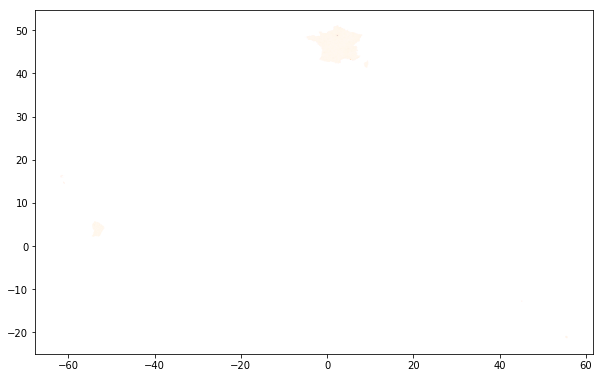

In [60]:
gdf_postal.plot(column="Population", figsize=(10,10), cmap='OrRd')

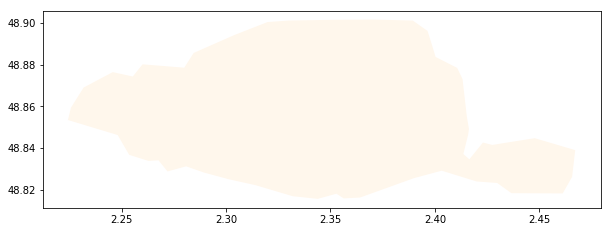

In [61]:
gdf_postal[[x.startswith("750") for x in gdf_postal.index]].plot(column="Population", figsize=(10,10), cmap='OrRd')

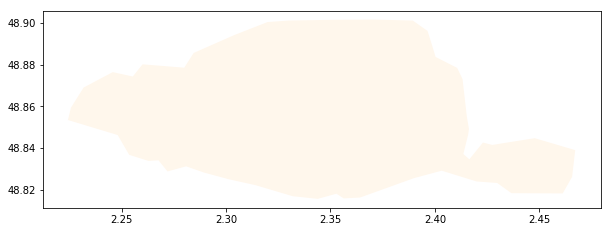

In [62]:
gdf_postal[[x.startswith("750") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["n_answers"])].plot(column="n_answers", figsize=(10,10), cmap='OrRd')

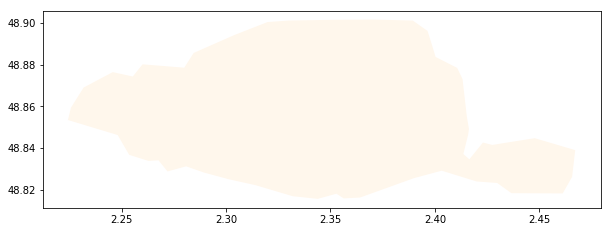

In [63]:
gdf_postal[[x.startswith("750") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["Proportion"])].plot(column="Proportion", figsize=(10,10), cmap='OrRd')

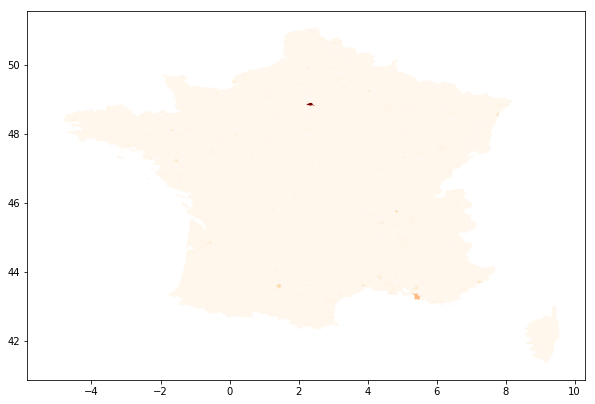

In [64]:
gdf_postal[[not x.startswith("97") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["Population"])].plot(column="Population", figsize=(10,10), cmap='OrRd')

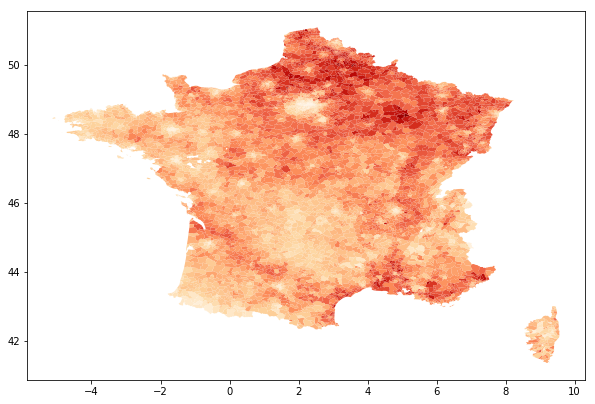

In [65]:
gdf_postal[[not x.startswith("97") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["LE PEN % Voix/Ins"])].plot(column="LE PEN % Voix/Ins", figsize=(10,10), cmap='OrRd')

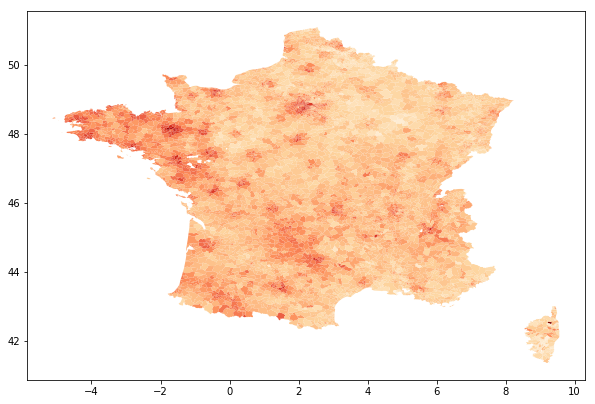

In [66]:
gdf_postal[[not x.startswith("97") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["MACRON % Voix/Ins"])].plot(column="MACRON % Voix/Ins", figsize=(10,10), cmap='OrRd')

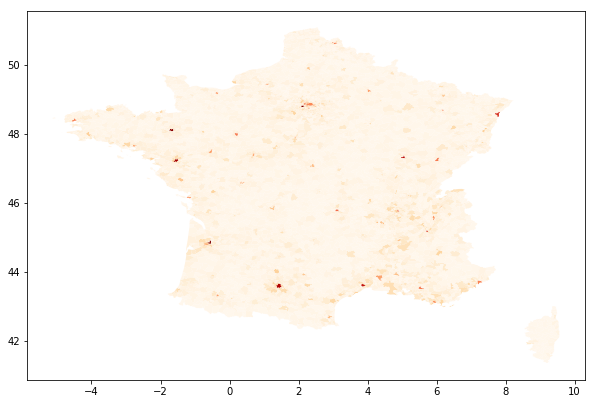

In [67]:
gdf_postal[[not x.startswith("97") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["n_answers"])].plot(column="n_answers", figsize=(10,10), cmap='OrRd')

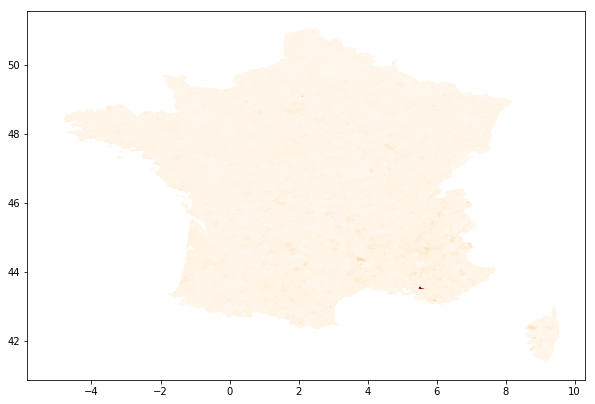

In [106]:
gdf_postal[[not x.startswith("97") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["Proportion"])].plot(column="Proportion", figsize=(10,10), cmap='OrRd')

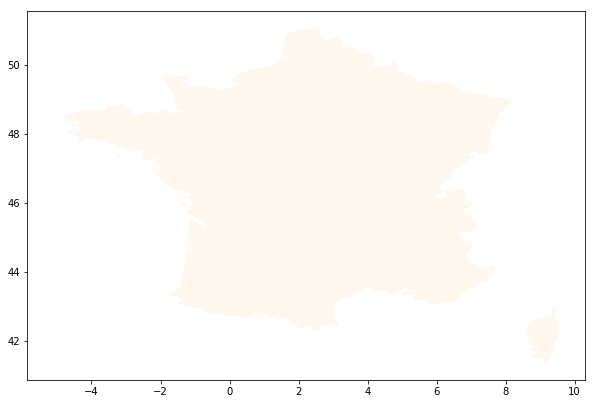

In [109]:
gdf_postal[[not x.startswith("97") for x in gdf_postal.index]
           & ~pd.isna(gdf_postal["Nb actifs travaillant dans autre commune"])].plot(column='Nb actifs travaillant dans autre commune', figsize=(10,10), cmap='OrRd')

In [70]:
df_postal_grp_dep = df_postal.groupby(by="Code Département")

In [71]:
df_postal.columns

Index(['Altitude Moyenne', 'Dynamique Entrepreneuriale',
       'Dynamique Entrepreneuriale Service et Commerce',
       'Synergie Médicale COMMUNE', 'Indice Fiscal Partiel', 'Score Fiscal',
       'Indice Evasion Client', 'Score Evasion Client',
       'Indice Synergie Médicale', 'Score Synergie Médicale',
       ...
       'Nb d'actifs de 15 ans ou plus ayant un emploi', 'Commune',
       'Département', 'Région', 'Statut', 'geo_point_2d', 'geo_shape',
       'Code Département', 'n_answers', 'Proportion'],
      dtype='object', length=126)

In [72]:
polygon_dep = json.load(open("france-geojson/departements.geojson"))

In [73]:
zip_to_polygon_dep = dict()
for poly in polygon_dep["features"]:
    if poly["geometry"]["type"] == "Polygon":
        polygon = Polygon(poly["geometry"]["coordinates"][0])
    else:
        polygon = reduce(lambda x,y: x.union(y),
                         [Polygon(x[0]) for x in poly["geometry"]["coordinates"]])
    zip_to_polygon_dep[poly["properties"]["code"]] = polygon

In [74]:
df_dep = pd.DataFrame()

In [75]:
df_dep["geometry"] = pd.Series(zip_to_polygon_dep)

In [76]:
for name in sum_indices:
    df_dep = df_dep.join(df_postal_grp_dep[name].agg(sum), how="outer")
df_dep = df_dep.join(df_postal_grp_dep["n_answers"].agg(sum), how="outer")
for name in mean_indices:
    df_dep = df_dep.join(df_postal_grp_dep[name].agg(np.mean), how="outer")

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:736: RuntimeWarning:

'<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:736: RuntimeWarning:

'<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects



In [77]:
df_dep["Proportion"] = df_dep["n_answers"] / df_dep["Population"]

In [78]:
gdf_dep = gpd.GeoDataFrame(df_dep)

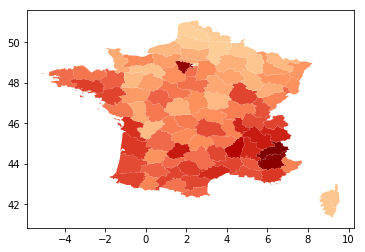

In [79]:
gdf_dep[pd.notna(gdf_dep["Proportion"])].plot(column="Proportion", cmap='OrRd')

In [80]:
gdf_dep["Revenu_Prop"] = gdf_dep["n_answers"] / gdf_dep["Moyenne Revenus Fiscaux Départementaux"]

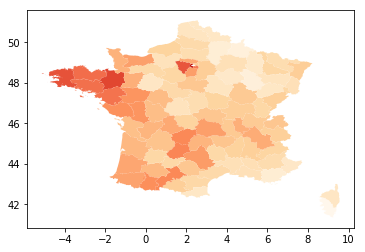

In [81]:
gdf_dep[pd.notna(gdf_dep["MACRON % Voix/Ins"])].plot(column="MACRON % Voix/Ins", cmap='OrRd')

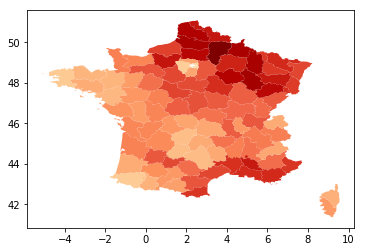

In [82]:
gdf_dep[pd.notna(gdf_dep["LE PEN % Voix/Ins"])].plot(column="LE PEN % Voix/Ins", cmap='OrRd')

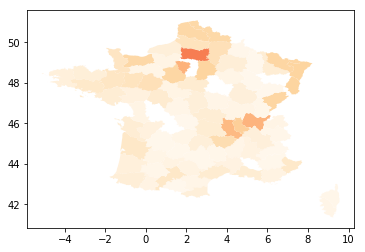

In [83]:
gdf_dep[pd.notna(gdf_dep["Couverture"])].plot(column="Couverture", cmap='OrRd')

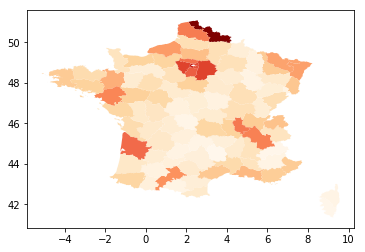

In [111]:
gdf_dep[pd.notna(gdf_dep["Nb actifs travaillant dans autre commune"])].plot(column="Nb actifs travaillant dans autre commune", cmap='OrRd')

# Can we do predictions?

In [84]:
for name in gdf_postal.columns:
    if name.startswith("Nb "):
        gdf_postal[name] = gdf_postal[name] / gdf_postal["Population"] / 1000

In [85]:
paris_loc = list(gdf_postal[gdf_postal.index == "75000"].geo_point_2d)[0]

In [86]:
toulouse = list(gdf_postal[gdf_postal.index == "31000"].geo_point_2d)[0]

In [87]:
gdf_postal["dist_paris"] = [paris_loc.distance(x)
                            for x in gdf_postal.geo_point_2d]

In [167]:
gdf_postal["main_city"] = [int(x > 10) for x in gdf_postal.Population]

In [162]:
import statsmodels.api as sm

In [324]:
all_indices = mean_indices + sum_indices
all_indices = [x for x in all_indices if not x.startswith("Indice")]
all_indices = [x for x in all_indices if not x.startswith("Score")]
#all_indices = [x for x in all_indices if not x.startswith("Nb ")]
all_indices = [x for x in all_indices if not x.startswith("Dep ")]
all_indices = [x for x in all_indices if not x.startswith("Reg ")]
all_indices = [x for x in all_indices if "/Exp" not in x]
#all_indices = [x for x in all_indices if not "INSEE" in x]
all_indices.remove("Dynamique Entrepreneuriale Service et Commerce")
all_indices.remove("Moyenne Revenus Fiscaux Départementaux")
all_indices.remove("Moyenne Revenus Fiscaux Régionaux")
all_indices.remove("PIB Régionnal")
all_indices.remove("Capacité Fisc")
all_indices.remove("Population")
all_indices.remove("Nb Logement Secondaire et Occasionnel")
all_indices.remove("Evolution Population")
all_indices.remove("Dynamique Entrepreneuriale")
all_indices.append("dist_paris")
all_indices.append("main_city")
all_indices.remove("Nb d'actifs de 15 ans ou plus ayant un emploi")
all_indices.remove("Nb Atifs")
all_indices.remove("Nb Actifs Salariés")
all_indices.remove("Nb Actifs Non Salariés")
#all_indices = [x for x in mean_indices + sum_indices if "%" in x and "Exp" not in x]
all_indices = [x for x in all_indices if "Vot" not in x]
#all_indices.remove("Evolution Pop %")

In [325]:
gdf_postal.to_csv("gdf_postal.csv")

In [335]:
df_indices = gdf_postal[all_indices + ["Proportion"]].dropna()
df = df_indices[all_indices]
X = (df - df.mean()) / (df.max() - df.min())

In [336]:
model = sm.OLS(df_indices["Proportion"], sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Proportion   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     20.30
Date:                Mon, 04 Mar 2019   Prob (F-statistic):          1.87e-199
Time:                        20:06:53   Log-Likelihood:                -6079.3
No. Observations:                5267   AIC:                         1.229e+04
Df Residuals:                    5203   BIC:                         1.271e+04
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
const                                                                  0.8309      0.011     78.102      0.000       0.810       0.852
Altitude Moyenne                                                       0.1659      0.136      1.217      0.223      -0.101       0.433
Synergie Médicale COMMUNE                                             -0.9994      7.088     -0.141      0.888     -14.895      12.896
Densité Médicale BV                                                    0.0828      0.033      2.533      0.011       0.019       0.147
Evolution Pop %                                                        0.1055      0.245      0.431      0.667      -0.375       0.586
Taux étudiants                                                        -2.9077      3.038     -0.957      0.339      -8.864       3.049
Taux Propriété                                                        -0.7489      0.157     -4.782      0.000      -1.056      -0.442
Dynamique Démographique INSEE                                          0.9953      2.752      0.362      0.718      -4.401       6.391
Capacité Fiscale                                                      -3.4331      5.294     -0.648      0.517     -13.812       6.946
Moyenne Revnus fiscaux                                                -0.0649      0.055     -1.184      0.237      -0.172       0.043
Taux Evasion Client                                                   -0.3787      3.730     -0.102      0.919      -7.691       6.933
Couverture                                                            -0.0891      0.078     -1.139      0.255      -0.243       0.064
% Abs/Ins                                                           -106.6889    112.941     -0.945      0.345    -328.101     114.724
% Blancs/Ins                                                         -13.8961     14.295     -0.972      0.331     -41.920      14.127
% Nuls/Ins                                                           -39.4723     41.707     -0.946      0.344    -121.235      42.290
% Exp/Ins                                                           -176.8202    122.874     -1.439      0.150    -417.706      64.065
LE PEN % Voix/Ins                                                     67.9649     60.942      1.115      0.265     -51.507     187.437
LASSALLE % Voix/Ins                                                   55.3662     49.242      1.124      0.261     -41.168     151.900
FILLON % Voix/Ins                                                     82.7310     73.173      1.131      0.258     -60.720     226.182
MACRON % Voix/Ins                                                     62.0750     54.587      1.137      0.256   

In [337]:
next_indices = list(results.pvalues[results.pvalues < 0.4].index)
if "const" in next_indices:
    next_indices.remove("const")
df_indices = gdf_postal[next_indices + ["Proportion"]].dropna()
df = df_indices[next_indices]
X = (df - df.mean()) / (df.max() - df.min())
X = (df - df.mean()) / (df.max() - df.min())

In [334]:
model = sm.OLS(df_indices["Proportion"], sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Proportion   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     51.74
Date:                Mon, 04 Mar 2019   Prob (F-statistic):          6.77e-181
Time:                        20:06:40   Log-Likelihood:                -6907.9
No. Observations:                5911   AIC:                         1.386e+04
Df Residuals:                    5891   BIC:                         1.399e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
const                                               0.8321      0.010     82.034      0.000       0.812       0.852
Densité Médicale BV                                 0.2662      0.028      9.616      0.000       0.212       0.320
Taux étudiants                                     -1.6555      0.610     -2.713      0.007      -2.852      -0.459
Taux Propriété                                     -0.9924      0.093    -10.721      0.000      -1.174      -0.811
Moyenne Revnus fiscaux                              0.1110      0.050      2.235      0.025       0.014       0.208
% Exp/Ins                                           1.6754      0.120     13.968      0.000       1.440       1.911
Nb Infirmiers Libéraux BV                          -1.5722      0.464     -3.387      0.001      -2.482      -0.662
Nb propriétaire                                     2.1919      0.257      8.529      0.000       1.688       2.696
Nb Occupants Résidence Principale                  -1.4837      0.306     -4.844      0.000      -2.084      -0.883
Nb Entreprises Secteur Services                     3.6512      0.546      6.684      0.000       2.580       4.722
Nb Entreprises Secteur Commerce                    -1.9119      0.424     -4.509      0.000      -2.743      -1.081
Nb Entreprises Secteur Construction                -0.3983      0.177     -2.251      0.024      -0.745      -0.051
Nb Création Industrielles                          -0.5021      0.263     -1.908      0.056      -1.018       0.014
Nb Création Commerces                               1.1292      0.198      5.709      0.000       0.741       1.517
Nb Education, santé, action sociale                 3.9264      0.539      7.285      0.000       2.870       4.983
Nb Services personnels et domestiques              -1.2516      0.258     -4.848      0.000      -1.758      -0.746
Nb Santé, action sociale                           -1.5363      0.518     -2.968      0.003      -2.551      -0.522
Nb actifs travaillant dans commune de résidence    -0.3717      0.225     -1.651      0.099      -0.813       0.070
Nb actifs travaillant dans autre commune            1.0804      0.195      5.542      0.000       0.698       1.463
dist_paris                                          0.3955      0.065      6.124      0.000       0.269       0.522
==============================================================================
Omnibus:                    11544.416   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         75240958.280
Skew:                          14.909   Prob(JB):                         0.00
Kurtosis:                     554.911   Cond. No.                         72.9
====================

In [230]:
params = results.params.sort_values()

In [231]:
iplot([go.Bar(x=params.index, y=params)])

In [232]:
from sklearn.linear_model import LinearRegression

In [242]:
df_indices = gdf_postal[all_indices + ["Proportion"]].dropna()
df = df_indices[all_indices]
X = (df - df.mean()) / (df.max() - df.min())

In [243]:
lr = LinearRegression()

In [244]:
lr = lr.fit(X, df_indices["Proportion"])

In [245]:
lr.score(X, df_indices["Proportion"])

0.19674599216634436

In [246]:
df_temp = pd.DataFrame(list(zip(next_indices, lr.coef_)), columns=["features", "coeff"])

In [247]:
df_temp.sort_values(by="coeff")

,features,coeff
14,Nb Services personnels et domestiques,-182.823799
11,Nb Création Commerces,-113.184538
13,"Nb Education, santé, action sociale",-41.892817
12,Nb Atifs,-14.740353
4,Nb Occupants Résidence Principale,-3.290581
7,Nb Entreprises Secteur Services,-1.989905
1,Taux Propriété,-0.909793
5,Nb Homme,-0.798575
10,Nb Création Industrielles,-0.095732
8,Nb Entreprises Secteur Commerce,-0.049751


In [248]:
from sklearn import linear_model

In [249]:
lasso = linear_model.Lasso(alpha=0.01)

In [250]:
lasso = lasso.fit(X, df_indices["Proportion"])

In [251]:
lasso.score(X, df_indices["Proportion"])

0.10585472941359209

In [252]:
from sklearn import tree

In [264]:
clf = tree.DecisionTreeClassifier(max_depth=4).fit(X, df_indices["Proportion"] > 0.7)

In [265]:
sum(df_indices["Proportion"] > 0.7) / len(df_indices["Proportion"])

0.5048414657300171

In [266]:
clf.score(X, df_indices["Proportion"] > 0.7)

0.6901461932789064

In [322]:
model = sm.Logit((df_indices["Proportion"] > 0.7).astype(int), df_indices[next_indices])
result = model.fit_regularized()

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1674: RuntimeWarning:

overflow encountered in exp



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5816079555393038
            Iterations: 215
            Function evaluations: 227
            Gradient evaluations: 215


In [323]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             Proportion   No. Observations:                 5911
Model:                          Logit   Df Residuals:                     5883
Method:                           MLE   Df Model:                           27
Date:                Mon, 04 Mar 2019   Pseudo R-squ.:                  0.1608
Time:                        20:05:28   Log-Likelihood:                -3437.9
converged:                       True   LL-Null:                       -4096.5
                                        LLR p-value:                9.512e-261
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Altitude Moyenne                             0.0002      0.000      1.325      0.185   -8.76e-05       0.000
Densité Médicale BV                          0.2875      0.086      3.344      0.001       0.119       0.456
Taux étudiants                              -0.1269      0.032     -3.996      0.000      -0.189      -0.065
Taux Propriété                              -0.0179      0.004     -4.520      0.000      -0.026      -0.010
% Blancs/Ins                                -0.2611      0.067     -3.905      0.000      -0.392      -0.130
LE PEN % Voix/Ins                            0.0018      0.008      0.234      0.815      -0.014       0.017
LASSALLE % Voix/Ins                         -0.0297      0.026     -1.153      0.249      -0.080       0.021
FILLON % Voix/Ins                            0.0565      0.009      6.560      0.000       0.040       0.073
MACRON % Voix/Ins                            0.0994      0.012      8.423      0.000       0.076       0.122
MÉLENCHON % Voix/Ins                         0.0437      0.010      4.391      0.000       0.024       0.063
ASSELINEAU % Voix/Ins                        0.1481      0.102      1.447      0.148      -0.053       0.349
Nb Infirmiers Libéraux BV                    0.0333      0.748      0.045      0.964      -1.432       1.499
Nb propriétaire                              9.5134      1.120      8.493      0.000       7.318      11.709
Nb Occupants Résidence Principale           -6.5389      1.279     -5.113      0.000      -9.045      -4.033
Nb Mineurs                                  -2.3098      1.100     -2.099      0.036      -4.467      -0.153
Nb Etudiants                                15.6928      3.085      5.087      0.000       9.646      21.740
Nb Entreprises Secteur Services             16.7327      5.419      3.088      0.002       6.111      27.354
Nb Entreprises Secteur Commerce            -23.2625      4.236     -5.491      0.000     -31.566     -14.959
Nb Entreprises Secteur Construction          1.5968     12.206      0.131      0.896     -22.326      25.520
Nb Création Construction                    47.3647     50.831      0.932      0.351     -52.262     146.992
Nb Création Commerces                      160.0442     41.569      3.850      0.000      78.571     241.517
Nb Actifs Salariés                           4.8672      1.143      4.259      0.000       2.627       7.107
Nb Actifs Non Salariés                       2.0508      1.796      1.142      0.254      -1.470       5.571
Nb Education, santé, action sociale        212.9704     44.492      4.787      0.000     125.768     300.173
Nb Services personnels et domestiques       55.4374     48.018      1.155      0.248     -38.675     149.550
Nb Santé, action sociale                   -47.5825     42.079     -1.131      0.258    -130.055      34.890
Nb actifs travaillant dans autre commune     0.8170      0.558      1.464      0